<a href="https://colab.research.google.com/github/viferraro/RedesFakeNews/blob/main/ISOTBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comando que instala a biblioteca transformers

In [1]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00


Comando que instala a biblioteca openpyxl, que é usada para ler e escrever arquivos do Excel.

In [2]:
!pip install openpyxl


Importação das bibliotecas necessárias

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.python.client import device_lib
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from transformers import AutoTokenizer, TFBertModel


Importa o módulo drive do pacote colab da biblioteca google. Esse módulo é usado para montar o Google Drive como um sistema de arquivos no Google Colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Comando que define a variável SEED como 10. Essa variável é usada para definir a semente do gerador de números aleatórios.

In [5]:
SEED = 10

Lê trata o arquivo Excel com o conjunto de dados

In [6]:
df = pd.read_excel('/content/drive/MyDrive/BDs/ISOT.xlsx')
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']
X = df['text']
y = df['saida']
MAX_LEN = 100


Cria uma função que retorna o número de palavras e cria os gráficos

Text(0.5, 1.0, 'Distribuição da contagem de palavras')

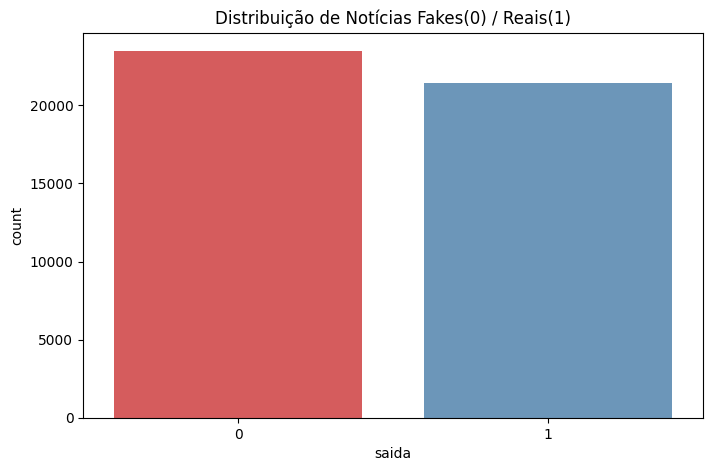

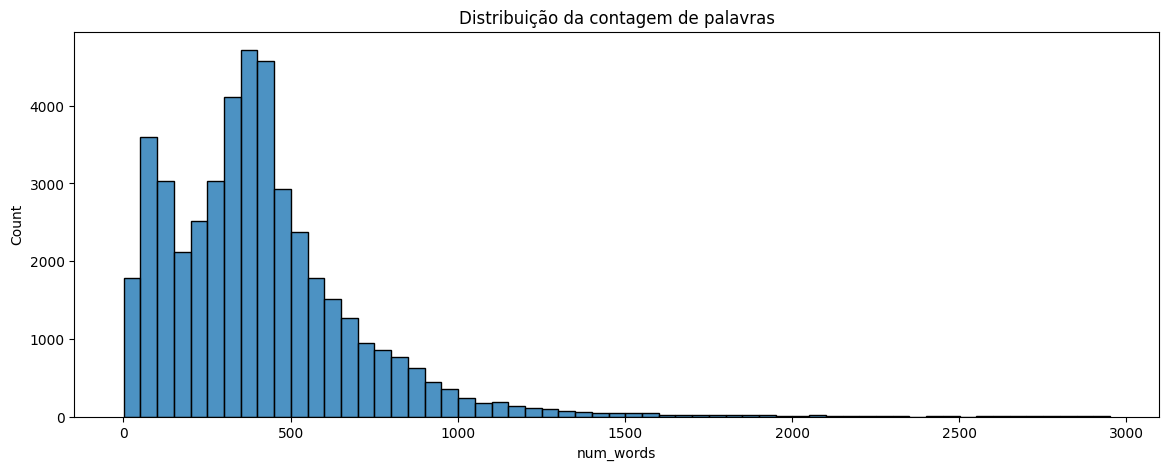

In [7]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (8,5))
sns.countplot(x = df['saida'], palette = 'Set1', alpha = 0.8)
plt.title('Distribuição de Notícias Fakes(0) / Reais(1)')
plt.figure(figsize = (14,5))
sns.histplot(df['num_words'], bins = range(1, 3000, 50), alpha = 0.8)
plt.title('Distribuição da contagem de palavras')

Define a função que cria e retorna o modelo (BERT)

In [8]:
def get_model():
    dropout_rate = 0.2
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    input_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
    embeddings = bert([input_ids, input_mask])[1]  # pooler output
    print(embeddings)
    out = Dropout(0.5)(embeddings)
    out = Dense(64, activation='relu', kernel_regularizer=l2(0.1), bias_regularizer=l1(0.1))(out)
    out = Dropout(0.5)(out)
    y = Dense(1, activation='sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
    return model

Define uma função que pré-processa o texto usando o tokenizer BERT

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                

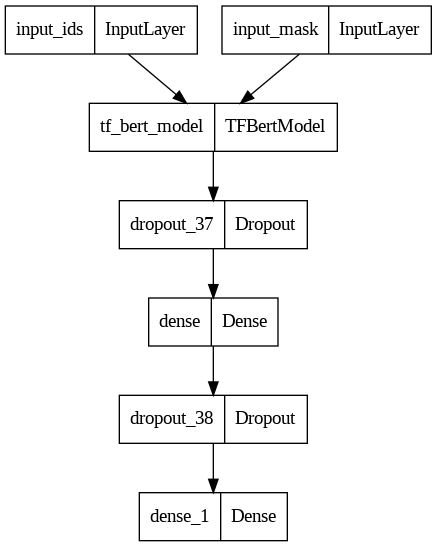

In [9]:
def get_tokens(X):
    X = tokenizer(
        text=list(X),
        add_special_tokens=True,
        max_length=MAX_LEN,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True)
    return X


tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')
model = get_model()
model.summary()
tf.keras.utils.plot_model(model)     #cria um diagrama mostrando a arquitetura do modelo

Divide os dados em conjuntos de treinamento, validação e teste.
Faz a tokenização e preenche os conjuntos de treinamento, validação e teste separadamente.

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.25, random_state=SEED)

training_tokens = get_tokens(X_train)
validation_tokens = get_tokens(X_val)
testing_tokens = get_tokens(X_test)

X_train_seq = {'input_ids': training_tokens['input_ids'], 'attention_mask': training_tokens['attention_mask']}
X_val_seq = {'input_ids': validation_tokens['input_ids'], 'attention_mask': validation_tokens['attention_mask']}
X_test_seq = {'input_ids': testing_tokens['input_ids'], 'attention_mask': testing_tokens['attention_mask']}

Realiza o treino

In [11]:
history = model.fit(x={'input_ids': X_train_seq['input_ids'], 'input_mask': X_train_seq['attention_mask']},
                    y=y_train,
                    validation_data=({'input_ids': X_test_seq['input_ids'], 'input_mask': X_test_seq['attention_mask']}, y_test),
                    epochs=10,
                    batch_size=16,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False,
                                             restore_best_weights=True)])


Epoch 1/10
1684/1684 [==============================] - 275s 150ms/step - loss: 8.8208 - accuracy: 0.9875 - val_loss: 6.1202 - val_accuracy: 0.9993
Epoch 2/10
1684/1684 [==============================] - 249s 148ms/step - loss: 4.1891 - accuracy: 0.9994 - val_loss: 2.5731 - val_accuracy: 0.9997
Epoch 3/10
1684/1684 [==============================] - 249s 148ms/step - loss: 1.6062 - accuracy: 0.9999 - val_loss: 0.9012 - val_accuracy: 0.9996
Epoch 4/10
1684/1684 [==============================] - 249s 148ms/step - loss: 0.5245 - accuracy: 0.9997 - val_loss: 0.2507 - val_accuracy: 0.9997
Epoch 5/10
1684/1684 [==============================] - 249s 148ms/step - loss: 0.1271 - accuracy: 0.9999 - val_loss: 0.0481 - val_accuracy: 0.9997


Cria gráficos que que mostram o desempenho do modelo

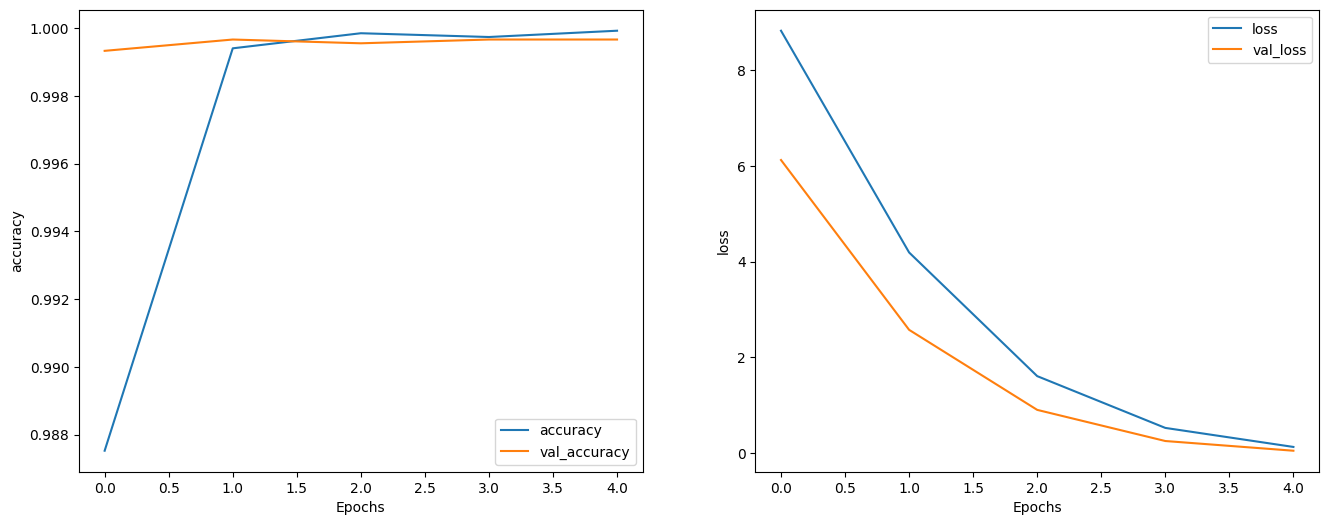

In [12]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Usa o modelo treinado para fazer previsões nos dados de teste

In [13]:
yhat = np.where(model.predict({'input_ids': X_test_seq['input_ids'], 'input_mask': X_test_seq['attention_mask']}) >= 0.5, 1, 0)

281/281 [==============================] - 25s 81ms/step


Imprime um resumo mostrando o desempenho do modelo nos dados do teste

In [14]:
print(classification_report(y_test,yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4283

    accuracy                           1.00      8979
   macro avg       1.00      1.00      1.00      8979
weighted avg       1.00      1.00      1.00      8979



Cria um diagrama mostrando a matriz de confusão

Text(70.72222222222221, 0.5, 'Real Labels')

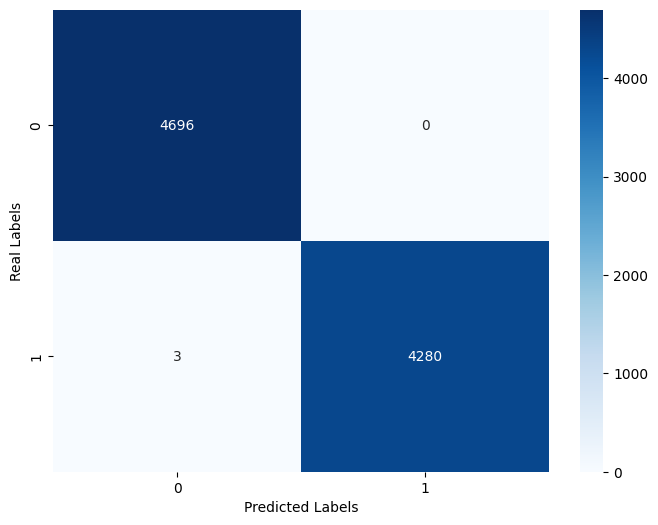

In [15]:
plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test,yhat), annot=True,
            fmt='', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

Salva o modelo e os pesos

In [16]:
model.save('ISOT_bert.h5')
model.save_weights("ISOT_bert_weights")